# Session 03 - Temporal Difference Learning - Assignment

## 1. Cliff walking

Implement Q-learning and SARSA to solve the cliff walking environment. The cliff walking environment is part of the gymgrid package. 
To install gymgryd: **pip3 install gymgrid**. More information can be found here: https://pypi.org/project/gymgrid/.
The goal for the agent is to find its way from start to finish without falling from the cliff. This is a standard episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked Cliff. Stepping into this region incurs a reward of optimal path -100 and sends the agent instantly back to the start.

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.

- Modify you Q-learing implementation to a SARSA implementation.

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 


In [1]:
# Cliff walking

import gymgrid
import numpy as np
import gym
import random
import matplotlib.pyplot as plt

In [2]:
# load the environment
env = gym.make('cliff-v0')


In [67]:
def make_epsilon_greedy_policy(q_table, epsilon, nA):

        # A = np.ones(nA, dtype=float) * epsilon / nA
        # best_action = np.argmax(Q[observation])
        # A[best_action] += (1.0 - epsilon)
        # return A

    def policy_fn(state):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(q_table[state])
        A[best_action] += (1.0 - epsilon) # Give the best action more chanse to be picked by the learning model
        return A
    return policy_fn

def rolling_average(rewards, window=3):
    averages = []
    for i in range(0, len(rewards) - window):
        moving_avg = 0
        for j in range(window):
            moving_avg += rewards[i+j]
        averages.append(moving_avg / window)
    return averages

In [4]:
def discretize_state(state):
    global bins
    discrete_state = ''
    for i in range(len(state)):
        discrete_state += str(np.digitize(state[i], bins[i]))
    return discrete_state


In [98]:
from collections import defaultdict

def q_learning(env, num_episodes, discount=1.0, learning_rate=0.5, epsilon=0.1, decay=0.9, discretization=False):
    
    q_table = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = {
        'mean': np.zeros(num_episodes),
        'total': np.zeros(num_episodes)
    }
    # The policy we're following

    policy = make_epsilon_greedy_policy(q_table, epsilon, env.action_space.n)
    
    for i in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i + 1, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset() if not discretization else discretize_state(env.reset())
        mean_reward = 0
        total_reward = 0
        
        for t in range(200):
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            if discretization:
                next_state = discretize_state(next_state)
            
            mean_reward = mean_reward + ((reward - mean_reward) / (i+1))
            total_reward += reward
            
            # Pick best next state based on optimism
            best_next_action = np.argmax(q_table[next_state])  
            learned_value = reward + discount * q_table[next_state][best_next_action]
            td_delta = learned_value - q_table[state][action]
            # q_table[state][action] = (1 - learning_rate) * q_table[state][action] + learning_rate * td_target
            q_table[state][action] += learning_rate * td_delta

                
            if done:
                break
                
            state = next_state

        learning_rate = learning_rate * decay

        rewards['mean'][i] = mean_reward
        rewards['total'][i] = total_reward
    
    return q_table, rewards

In [87]:
def sarsa(env, num_episodes, discount=1.0, learning_rate=0.5, epsilon=0.1, decay=0.9, discretization=False):
    q_table = defaultdict(lambda: np.zeros(env.action_space.n))    
    rewards = {
        'mean': np.zeros(num_episodes),
        'total': np.zeros(num_episodes)
    }

    policy = make_epsilon_greedy_policy(q_table, epsilon, env.action_space.n)

    
    for i in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i + 1, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset() if not discretization else discretize_state(env.reset())
        mean_reward = 0
        total_reward = 0
        
        # One step in the environment
        for t in range(200):
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            if discretization:
                next_state = discretize_state(next_state)
            
            # Pick the next action based on policy
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            mean_reward = mean_reward + ((reward - mean_reward) / (i+1))
            total_reward += reward

            # TD Update
            learned_value = reward + discount * q_table[next_state][next_action]
            td_delta = learned_value - q_table[state][action]
            # q_table[state][action] = (1.0 - learning_rate) * q_table[state][action] + learning_rate * td_delta
            q_table[state][action] += learning_rate * td_delta
    
            if done:
                break
                
            state = next_state

        learning_rate = learning_rate * decay

        rewards['mean'][i] = mean_reward
        rewards['total'][i] = total_reward    
    
    return q_table, rewards

In [99]:
episodes = 2000
%time q_table, q_rewards = q_learning(env, episodes, decay=1)
%time sarsa_table, sarsa_rewards = sarsa(env, episodes, decay=0.99)

Episode 2000/2000.CPU times: user 2.02 s, sys: 5.56 ms, total: 2.02 s
Wall time: 2.01 s
Episode 2000/2000.CPU times: user 3.65 s, sys: 30.4 ms, total: 3.68 s
Wall time: 3.67 s


&lt;matplotlib.legend.Legend at 0x7f01b62ecc40&gt;

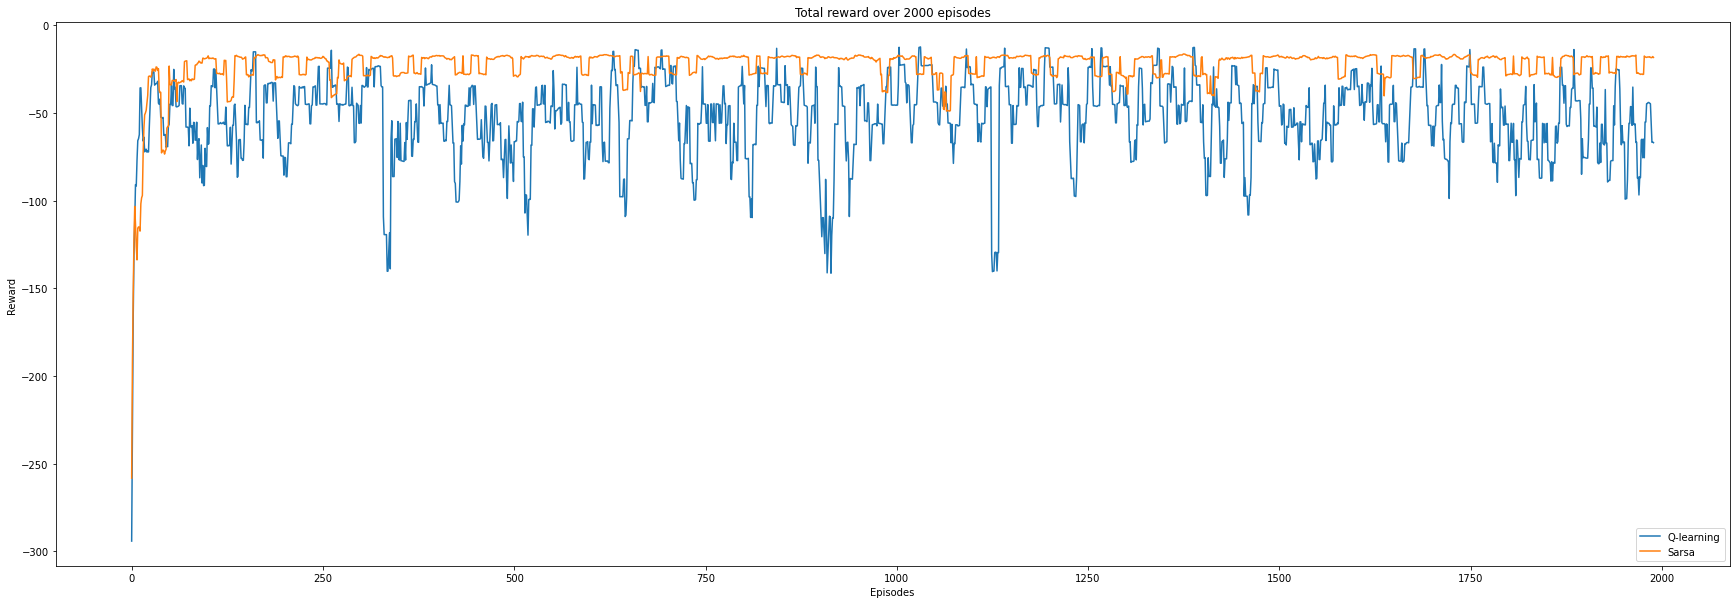

In [90]:
fig, ax1 = plt.subplots(ncols=1)
fig.set_figwidth(30)
fig.set_figheight(10)

ax1.plot(rolling_average(q_rewards['total'], 10), label='Q-learning')
ax1.plot(rolling_average(sarsa_rewards['total'], 10), label='Sarsa')
ax1.set_title(f'Total reward over {episodes} episodes')
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Reward')
ax1.legend(loc='lower right')

In [43]:
state = env.reset()

for i in range(50):
    state = env.reset()
    for i in range(200):        
        env.render()
        best_action = np.argmax(sarsa_table[state])
        state, reward, done, _ = env.step(best_action)
        if done: break

env.reset()
env.close()

## 2. The cartpole environment

Solve the cartpole environment by means of both Q-learning and SARSA. 
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Q-learing and SARSA take discrete states as inputs. The cartpole environments outputs continuous state vectors. 
Therefore you will have to discretize these continuous state vectors. 
For example the cart position can vary in the range of -2.4 -> 2.4. You will have to discretize this range in a number of bins (for example 10 bins).
The numpy function 'digitize' can be used for discretization. More information about this function: https://numpy.org/doc/stable/reference/generated/numpy.digitize.html

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.

- Modify you Q-learing implementation to a SARSA implementation.

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 


In [12]:
# Solving the cartpole environment

env_name = "CartPole-v0"
env_cart = gym.make(env_name) 

In [13]:
bins = [
    np.linspace(-4.81, 4.81, 10),
    np.linspace(-4, 4, 10),
    np.linspace(-0.4181, 0.4181, 10),
    np.linspace(-4, 4, 10),
]

In [91]:
episodes = 2000
%time q_table, q_rewards = q_learning(env_cart, episodes, learning_rate=0.7, decay=1, discretization=True)
%time sarsa_table, sarsa_rewards = sarsa(env_cart, episodes, learning_rate=0.8, discount=0.5, decay=1, discretization=True)

Episode 2000/2000.CPU times: user 4.95 s, sys: 223 ms, total: 5.18 s
Wall time: 4.95 s
Episode 2000/2000.CPU times: user 6.94 s, sys: 237 ms, total: 7.17 s
Wall time: 6.87 s


&lt;matplotlib.legend.Legend at 0x7f01b5c717f0&gt;

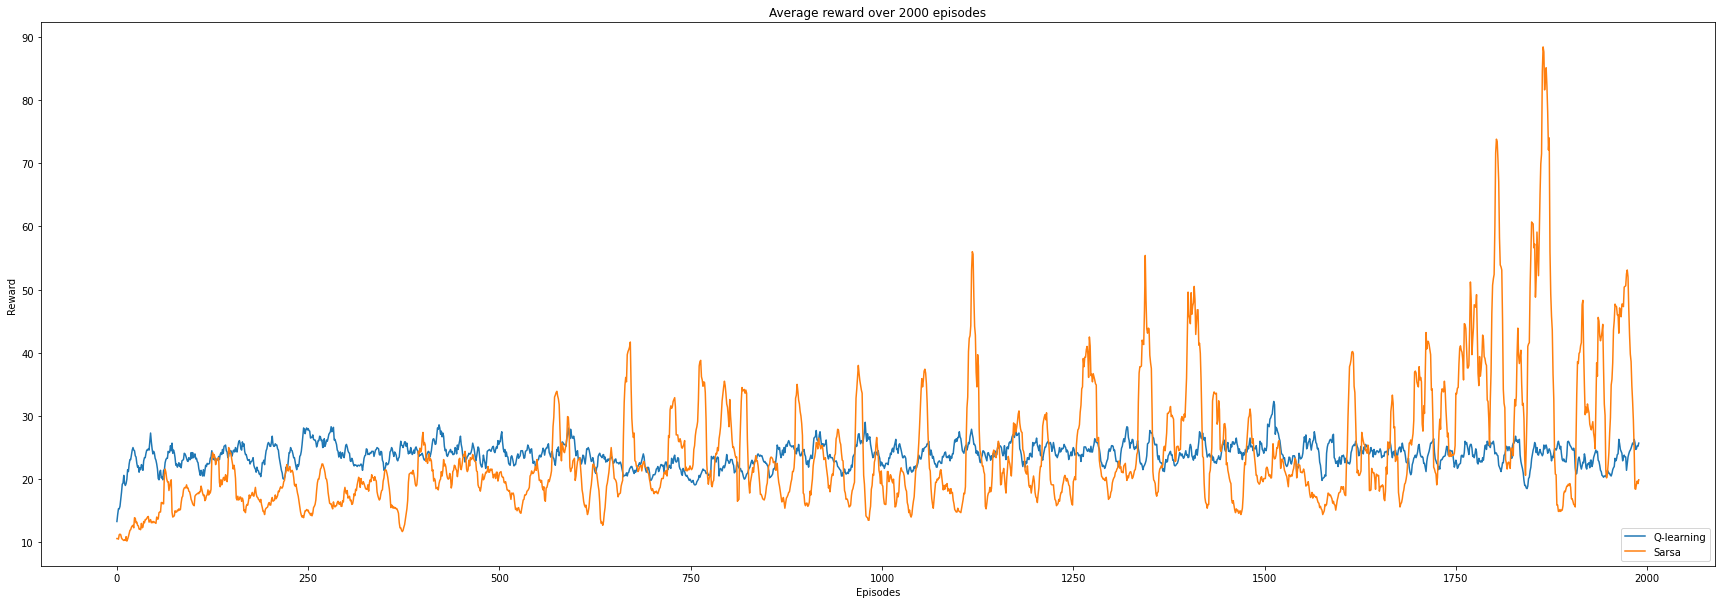

In [92]:
fig, ax1 = plt.subplots(ncols=1)
fig.set_figwidth(30)
fig.set_figheight(10)

ax1.plot(rolling_average(q_rewards['total'], 10), label='Q-learning')
ax1.plot(rolling_average(sarsa_rewards['total'], 10), label='Sarsa')
ax1.set_title(f'Average reward over {episodes} episodes')
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Reward')
ax1.legend(loc='lower right')

In [53]:
for i in range(200):
    state = env_cart.reset()
    for i in range(200):
        state = discretize_state(state)
        env_cart.render()
        best_action = np.argmax(sarsa_table[state])
        state, reward, done, _ = env_cart.step(best_action)
        if done: break

env_cart.reset()
env_cart.close()